# 空手道俱乐部风云 (SNA 全流程模拟考)

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
print('🥋 加载空手道俱乐部网络...')
G = nx.karate_club_graph()
## --- 2. 节点特征 (Node Level) ---
print('\n=== 第一题：节点特征分析 ===')
# A. 度中心性 (Degree): 谁认识的人最多？
deg_cen = nx.degree_centrality(G)
# B. 中介中心性 (Betweenness): 谁是沟通桥梁(权力的掮客)？
bet_cen=nx.betweenness_centrality(G)
# C. 接近中心性 (Closeness): 谁离大家都近(消息灵通)？
clo_cen = nx.closeness_centrality(G)
# 把结果整理成表格，方便看前3名
df_nodes = pd.DataFrame({
    '度中心性':deg_cen,
    '中介中心性':bet_cen,
    '接近中心性':clo_cen
})
# 打印前 5 名“大佬”
print(df_nodes.sort_values('度中心性',ascending=False).head(5))



🥋 加载空手道俱乐部网络...

=== 第一题：节点特征分析 ===
        度中心性     中介中心性     接近中心性
33  0.515152  0.304075  0.550000
0   0.484848  0.437635  0.568966
32  0.363636  0.145247  0.515625
2   0.303030  0.143657  0.559322
1   0.272727  0.053937  0.485294


In [5]:
# --- 3. 整体特征 (Network Level) ---
print('n=== 第二题：整体特征分析 ===')
# A. 密度 (Density): 实际连边 / 可能的最大连边
density = nx.density(G)
print(f'1. 网络密度:{density:.4f} (越接近1越紧密)')
# B. 平均路径长度 (Avg Path Length): 两个人认识平均要转几手？
if nx.is_connected(G):
    avg_path = nx.average_shortest_path_length(G)
    print(f'2. 平均路径长度: {avg_path:.4f}步')
else:
    print('2. 网络不连通，无法计算平均路径')
# C. 直径 (Diameter): 最远的两个人隔了多远？
diameter = nx.diameter(G)
print(f'3. 网络直径:{diameter}步')
# D. 聚类系数 (Transitivity): 朋友的朋友也是朋友吗？
transitivity =nx.transitivity(G)
print(f'4. 传递性(聚类系数):{transitivity:.4f}')

n=== 第二题：整体特征分析 ===
1. 网络密度:0.1390 (越接近1越紧密)
2. 平均路径长度: 2.4082步
3. 网络直径:5步
4. 传递性(聚类系数):0.2557


In [8]:
# --- 4. 块模分析 (Blockmodeling) ---
# 这是 Python 做 SNA 最麻烦的地方，请仔细看逻辑
print('\n=== 第三题：块模分析 (核心) ===')
# A. 划分“块” (Partitioning)
# 我们用一种算法(G-N算法)把人分成 2 个社群 (Block)
communities_generator=community.girvan_newman(G)
top_level_communities = next(communities_generator)
partition = sorted(map(sorted,top_level_communities))
print(f'网络被划分成了{len(partition)}个块 (社群)。')
print(f'块1(人数{len(partition[0])}):{partition[0]}')
print(f'块1(人数{len(partition[1])}):{partition[1]}')
# B. 计算“块密度矩阵” (Image Matrix)
# 逻辑：算出 块1内部、块2内部、块1-块2之间 的连边密度
block_density_martix = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        # 找出属于块i和块j的节点
        nodes_i = partition[i]
        nodes_j = partition[j]
        # 算出这两个块之间可能的最大连边数
        if i == j:
            possible_edges=len(nodes_i) * (len(nodes_i)-1)# 有向图不用除2，无向图看NetworkX定义，这里简化处理
        else:
            possible_edges = len(nodes_i) * len(nodes_j)
        # 算出实际存在的连边数
        # subgraph: 把子图切出来
        # edges: 数边
        # 这是一个简化算法，严谨的块模需要遍历所有边
        actual_edges=0
        for u in nodes_i:
            for v in nodes_j:
                if G.has_edge(u,v):
                    actual_edges +=1
        # 计算密度
        block_density=actual_edges/possible_edges
        block_density_martix[i,j]=block_density
print('\n块密度矩阵 (Block Density Matrix):')
print(block_density_martix)
# C. 像矩阵 (Image Matrix) - 设定阈值把密度变 0/1
# 常用阈值是“整体密度”
threshold = density
image_martix=np.where(block_density_martix > threshold,1,0)
print(f'\n像矩阵 (阈值={threshold:.4f}):')
print(image_martix)
print('(1代表该块之间连接紧密，0代表疏松)')


=== 第三题：块模分析 (核心) ===
网络被划分成了2个块 (社群)。
块1(人数15):[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
块1(人数19):[2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

块密度矩阵 (Block Density Matrix):
[[0.26666667 0.03508772]
 [0.03508772 0.23391813]]

像矩阵 (阈值=0.1390):
[[1 0]
 [0 1]]
(1代表该块之间连接紧密，0代表疏松)


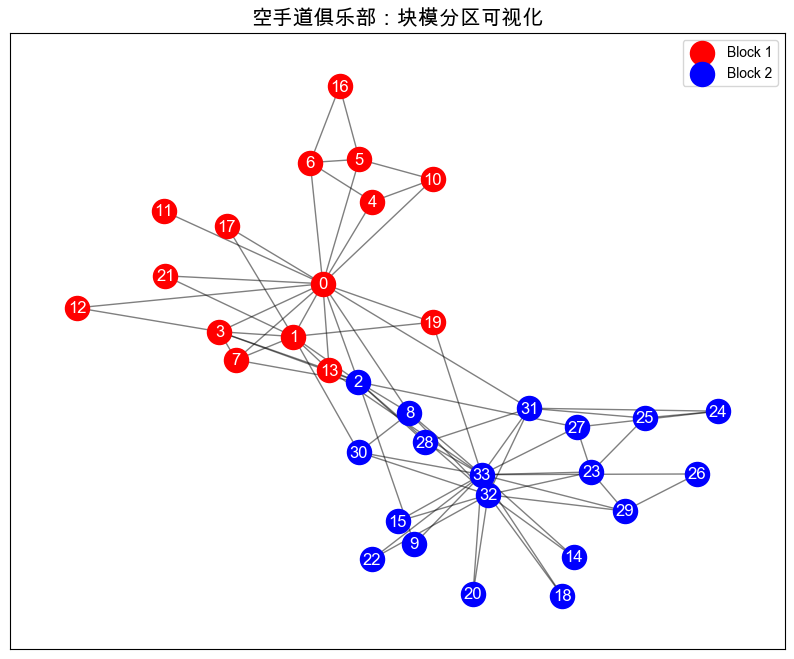

In [9]:
plt.figure(figsize=(10,8))
pos = nx.spring_layout(G,seed=42)# 固定布局
# 画节点：根据所属的块上色
# 块1用红色，块2用蓝色
nx.draw_networkx_nodes(G,pos,nodelist=partition[0],node_color='red',label='Block 1')
nx.draw_networkx_nodes(G,pos,nodelist=partition[1],node_color='blue',label='Block 2')
# 画边和标签
nx.draw_networkx_edges(G,pos,alpha=0.5)
nx.draw_networkx_labels(G,pos,font_color='white')
plt.title('空手道俱乐部：块模分区可视化',fontsize=15)
plt.legend()
plt.show()
